In [1]:
from dedalus.tools.config import config
config['linear algebra']['use_fftw'] = 'True'
config['linear algebra']['matrix_solver'] = 'lu'

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import os
from matplotlib.animation import FuncAnimation
logger = logging.getLogger(__name__)

# Parameters
Lx = 2 * np.pi  # size of domain
Nx = 128  # no of points in mesh
Ly = 2 * np.pi
Ny = 128
beta = 10      # planetary vorticity 
dealias = 3 / 2
stop_sim_time = 12
timestepper = d3.CNAB2 # Change timestepper to CNAB2 (Crank-Nicolson Adams-Bashforth)
timestep = 0.01
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
ycoord = d3.Coordinate('y')

dist = d3.Distributor([xcoord, ycoord], dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(-np.pi, np.pi), dealias=dealias)
ybasis = d3.RealFourier(ycoord, size=Ny, bounds=(-np.pi, np.pi), dealias=dealias)

# Fields
psi = dist.Field(name='psi', bases=(xbasis, ybasis))
zeta = dist.Field(name='zeta', bases=(xbasis, ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis,ybasis))

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
dy = lambda A: d3.Differentiate(A, ycoord)
delta = lambda A: dx(dx(A)) + dy(dy(A))


# Problem
problem = d3.IVP([psi, zeta,u,v], namespace=locals())
problem.add_equation("dt(psi) - u*dy(zeta) + v*dx(zeta) + beta*dx(psi) = 0")
problem.add_equation("zeta - delta(psi) = 0")

# Initial conditions
sigma = 1
x = psi.domain.grids(scales=psi.dealias)[0]
y = psi.domain.grids(scales=psi.dealias)[1]
XX, YY = np.meshgrid(x, y, indexing='ij')
psi['g'] = XX * np.exp(-(XX**2 + YY**2) / (2 * sigma**2))
delta(psi).evaluate(zeta)

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
psi.change_scales(1)
zeta.change_scales(1)
psi_list = [np.copy(psi['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    psi.change_scales(1)
    zeta.change_scales(1)
    u['g'] = -dy(psi)['g']
    v['g'] = dx(psi)['g']
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        psi.change_scales(1)
        zeta.change_scales(1)
        psi_list.append(np.copy(psi['g']))
        t_list.append(solver.sim_time)


UnsupportedEquationError: IVP LHS is nonlinear in problem variables.

In [ ]:
# Plot/ Movie
fig, ax = plt.subplots(figsize=(6, 6))


def animate(i):
    """
    Animation function that updates the plot at each time step.

    Args:
        i (int): The current frame number (time step).
    """

    ax.clear()

    ax.set_title(f'Time: {t_list[i]:.2f}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

    im = ax.imshow(psi_list[i].T, cmap='coolwarm', aspect='auto',
                   extent=[x.min(), x.max(), y.min(), y.max()],
                   origin='lower', interpolation='bicubic')

    return im,


ani = FuncAnimation(fig, animate, frames=len(psi_list), blit=True)

ani.save('barotropic_vorticity_animation.gif', writer='imagemagick', fps=10)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import os
from matplotlib.animation import FuncAnimation
logger = logging.getLogger(__name__)


# Parameters
Lx = 2 * np.pi  # size of domain
Nx = 128  # no of points in mesh
Ly = 2 * np.pi
Ny = 128
beta = 10      # planetary vorticity 
sigma = 1
dealias = 3 / 2
stop_sim_time = 10
timestepper = d3.SBDF2 
timestep = 0.01
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
ycoord = d3.Coordinate('y')

dist = d3.Distributor([xcoord, ycoord], dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(-np.pi, np.pi), dealias=dealias)
ybasis = d3.RealFourier(ycoord, size=Ny, bounds=(-np.pi, np.pi), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis,ybasis))
psi = dist.Field(name='psi', bases=(xbasis, ybasis))
zeta = dist.Field(name='zeta', bases=(xbasis, ybasis))

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
dy = lambda A: d3.Differentiate(A, ycoord)
delta = lambda A: dx(dx(A)) + dy(dy(A))

# Problem
problem = d3.IVP([psi,zeta], namespace=locals())
#problem.add_equation("u + dy(psi) = 0")
#problem.add_equation("v - dx(psi) = 0")
coeff_filter = {'x': lambda x: x != 0, 'y': lambda y: y != 0}
problem.add_equation("zeta - delta(psi) = 0", coeff_filter=coeff_filter)
problem.add_equation("dt(zeta) + beta*dx(psi) = dy(psi)*dx(zeta) - dx(psi)*dy(zeta)")
#problem.add_equation("integ(psi) = 0") # Pressure gauge

# Initial conditions
x_0 = 0
y_0 = 0
sigma = 1
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
XX, YY = np.meshgrid(x, y, indexing='ij')
u['g'] = np.zeros_like(dist.local_grid(xbasis))
v['g'] = np.zeros_like(dist.local_grid(xbasis))
zeta['g'] = np.zeros_like(dist.local_grid(xbasis))
psi['g'] = XX * np.exp(-((XX-x_0)**2 + (YY-y_0)**2)/(2*(sigma**2)))


# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
v.change_scales(1)
psi.change_scales(1)
zeta.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        v.change_scales(1)
        psi.change_scales(1)
        zeta.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import os
from matplotlib.animation import FuncAnimation
logger = logging.getLogger(__name__)


# Parameters
Lx = 2 * np.pi  # size of domain
Nx = 128  # no of points in mesh
Ly = 2 * np.pi
Ny = 128
beta = 10      # planetary vorticity 
sigma = 1
#dealias = 3 / 2
dealias = 1
stop_sim_time = 1
timestepper = d3.SBDF2
timestep = 0.001
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
ycoord = d3.Coordinate('y')

dist = d3.Distributor([xcoord, ycoord], dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(-np.pi, np.pi), dealias=dealias)
ybasis = d3.RealFourier(ycoord, size=Ny, bounds=(-np.pi, np.pi), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis,ybasis))
psi = dist.Field(name='psi', bases=(xbasis, ybasis))
zeta = dist.Field(name='zeta', bases=(xbasis, ybasis))
tau = dist.Field(name='tau')

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
dy = lambda A: d3.Differentiate(A, ycoord)
delta = lambda A: dx(dx(A)) + dy(dy(A))

# Problem
problem = d3.IVP([psi,zeta, tau], namespace=locals())
#problem.add_equation("u + dy(psi) = 0")
#problem.add_equation("v - dx(psi) = 0")
problem.add_equation("zeta - delta(psi) + tau = 0")
problem.add_equation("dt(zeta) + beta*dx(psi) = dy(psi)*dx(zeta) - dx(psi)*dy(zeta)")
problem.add_equation("integ(psi) = 0")

# Initial conditions
x_0 = 0
y_0 = 0
sigma = 1
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
XX, YY = np.meshgrid(x, y, indexing='ij')
#u['g'] = np.zeros_like(dist.local_grid(xbasis))
#v['g'] = np.zeros_like(dist.local_grid(xbasis))
psi['g'] = 0.1 * XX * np.exp(-((XX-x_0)**2 + (YY-y_0)**2)/(2*(sigma**2)))
zeta['g'] = delta(psi).evaluate()['g']


# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
v.change_scales(1)
psi.change_scales(1)
zeta.change_scales(1)
zeta_list = [np.copy(zeta['g'])]
psi_list = [np.copy(psi['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        v.change_scales(1)
        psi.change_scales(1)
        zeta.change_scales(1)
        zeta_list.append(np.copy(zeta['g']))
        psi_list.append(np.copy(psi['g']))
        t_list.append(solver.sim_time)


2023-08-11 17:15:27,560 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2023-08-11 17:15:27,590 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2023-08-11 17:15:27,625 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2023-08-11 17:15:27,659 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+02/s
2023-08-11 17:15:27,698 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2023-08-11 17:15:27,743 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2023-08-11 17:15:27,775 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2023-08-11 17:15:27,808 subsystems 0/1 INFO :: Building subproblem matri

In [3]:
zeta_list[1]

array([[ 0.0188074 ,  0.02568631,  0.0291658 , ...,  0.03405374,
         0.0291663 ,  0.02568361],
       [-0.00794567, -0.00483241, -0.00646195, ..., -0.00719448,
        -0.00646736, -0.00483491],
       [-0.00259863,  0.00196208,  0.00133484, ...,  0.00189138,
         0.00133774,  0.00196436],
       ...,
       [ 0.00320752, -0.00195193, -0.00117859, ..., -0.00174197,
        -0.00117748, -0.00195148],
       [ 0.00830236,  0.00462708,  0.00635541, ...,  0.00702863,
         0.00635427,  0.00462741],
       [-0.01803307, -0.02533832, -0.02864439, ..., -0.03347245,
        -0.02864126, -0.02533354]])

In [4]:
zeta['g'].shape

(128, 128)

In [5]:
psi['g'].shape

(128, 128)

In [6]:
delta(psi).evaluate()['g'].shape

(128, 128)

In [7]:
XX.shape

(128, 128)

In [8]:
(XX * np.exp(-((XX-x_0)**2 + (YY-y_0)**2)/(2*(sigma**2)))).shape

(128, 128)

In [9]:
psi['g']=(XX * np.exp(-((XX-x_0)**2 + (YY-y_0)**2)/(2*(sigma**2))))

In [10]:
print(psi_list)

[array([[-1.61320690e-05, -1.87782485e-05, -2.18512409e-05, ...,
        -2.53206292e-05, -2.18512409e-05, -1.87782485e-05],
       [-1.87782479e-05, -2.18584861e-05, -2.54355482e-05, ...,
        -2.94740279e-05, -2.54355482e-05, -2.18584861e-05],
       [-2.12114049e-05, -2.46907593e-05, -2.87313127e-05, ...,
        -3.32930710e-05, -2.87313127e-05, -2.46907593e-05],
       ...,
       [ 2.42206845e-05,  2.81936579e-05,  3.28074479e-05, ...,
         3.80163867e-05,  3.28074479e-05,  2.81936579e-05],
       [ 2.14654532e-05,  2.49864798e-05,  2.90754267e-05, ...,
         3.36918211e-05,  2.90754267e-05,  2.49864798e-05],
       [ 1.85241995e-05,  2.15627656e-05,  2.50914341e-05, ...,
         2.90752778e-05,  2.50914341e-05,  2.15627656e-05]]), array([[-0.0019488 , -0.00195329, -0.0019619 , ..., -0.00197469,
        -0.00196197, -0.00195332],
       [-0.0019302 , -0.00193509, -0.00194415, ..., -0.00195746,
        -0.00194424, -0.00193513],
       [-0.00190783, -0.0019131 , -0.0019

2023-08-11 17:19:57,661 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-08-11 17:19:57,661 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


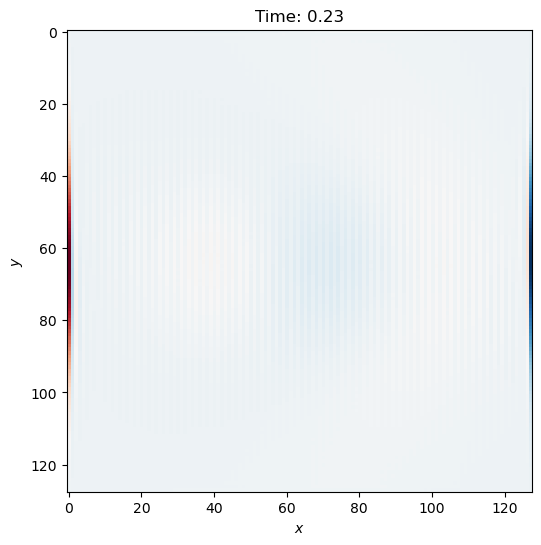

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

def animate(i):
    """
    Animation function that updates the plot at each time step.
    
    Args:
        i (int): The current frame number (time step).
    """
    
    ax.clear()
    

    ax.set_title(f'Time: {t_list[i]:.2f}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    

    im = ax.imshow(zeta_list[i].T, cmap='RdBu_r', aspect='auto')
    
    return im,


ani = FuncAnimation(fig, animate, frames=10, blit=True)

ani.save('wave_animation.gif', writer='imagemagick', fps=10)

plt.show()